#Anlysis packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',100)

#Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')

In [ ]:
direc='/content/drive/MyDrive/주피터_대피소/kaggle&github/2. Driver Prediction/'

train=pd.read_csv(direc+'train.csv')
test=pd.read_csv(direc+'test.csv')



#Few quick observations

we can make few observations based on the data description in the competition :

- Few groups are defined and features that belongs to these groups include patterns in the name. The **ind** indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field ;
- The postfix bin is used for binary features;
- The postfix cat to is used for categorical featuers ;
- Features without the bin or cat indications are real numbers (continuous values) of integers (ordinal values) ;
- A missing valu is indicated by -1;
0 The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
- id is a data input ordinal number.

Let's glimpse the data to see if these interpretations are confirmed.

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
print('Train has {} rows and {} cols'.format(train.shape[0],train.shape[1]))

print('and test has {} rows and {} cols'.format(test.shape[0],test.shape[1]))

Train has 595212 rows and 59 cols
and test has 892816 rows and 58 cols


There are 59 cols in the train and only 58 cols in test. Since from this dataset sould have been extracted the target, this seems fine, Let's check the difference btw the columns set in the two datasets, to make sure everything is fine.

In [ ]:
print('Columns in train and not in test data is : {}'.format(set(train.columns)-set(test.columns)))

Columns in train and not in test data is : {'target'}


#Introduction of metadata

In [ ]:
data = []

for feature in train.columns :
  #defining the role
  if feature == 'target' :
    use = 'target'
  elif feature == 'id' :
    use = 'id'
  else :
    use = 'input'

  #defining the type
  if 'bin' in feature or feature == 'target' :
    type = 'binary'
  elif 'cat' in feature or feature == 'id' :
    type = 'categorical'
  elif train[feature].dtype == float or isinstance(train[feature].dtype, float) :
    type = 'real'
  elif train[feature].dtype == int :
    type = 'integer'

  preserve = True
  if feature == 'id' :
    preserve = False
  
  #difining the datatype
  dtype = train[feature].dtype
  
  #defining the category
  category = 'None'
  if 'ind' in feature :
    category = 'individual'
  elif 'reg' in feature :
    category = 'registration'
  elif 'car' in feature :
    category = 'car'
  elif 'calc' in feature :
    category = 'calculated'

  #Creating a dict that contains all the metadata for the variable
  feature_dictionary = {
      'varname' : feature,
      'use' : use,
      'type' : type,
      'preserve' : preserve,
      'dtype' : dtype,
      'category' : category
  }
  data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname','use','type','preserve','dtype','category'])

metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,None
target,target,binary,True,int64,None
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


We can extract all categorical values :

In [ ]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Let's inspect all features, to see how many categorical distinct values do we have :

In [ ]:
pd.DataFrame( {'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,None,2
1,calculated,20
2,car,16
3,individual,18
4,registration,3


In [ ]:
pd.DataFrame({'count' : metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


#Data analysis and statistics

##Target variable

<Figure size 432x288 with 0 Axes>

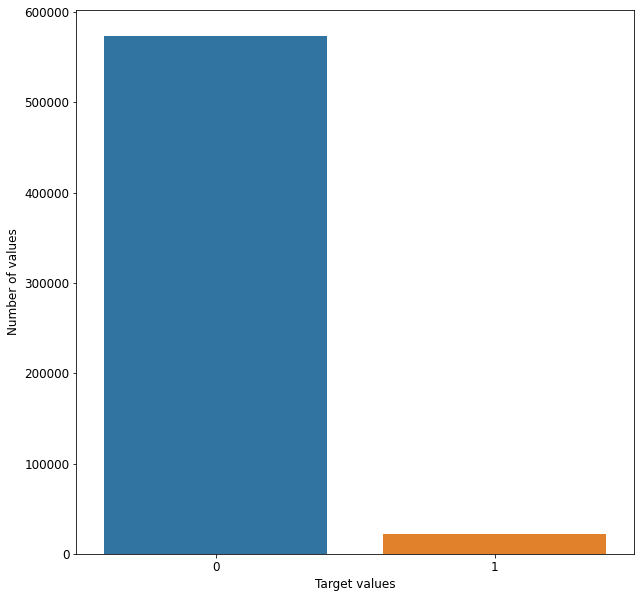

In [ ]:
plt.figure()
fig,ax = plt.subplots(figsize=(10,10))

x=train['target'].value_counts().index.values
y=train['target'].value_counts().values

sns.barplot(x=x,y=y, ax=ax)
plt.xlabel('Target values', fontsize=12)
plt.ylabel('Number of values', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

##Real Features

In [ ]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index

train[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [ ]:
pow(train['ps_car_12']*10,2).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [ ]:
pow(train['ps_car_15'],2).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

Features with missing values

ps_reg_03,12,14

Registration features

ps_reg_01,02 are fractions with deniminator 10

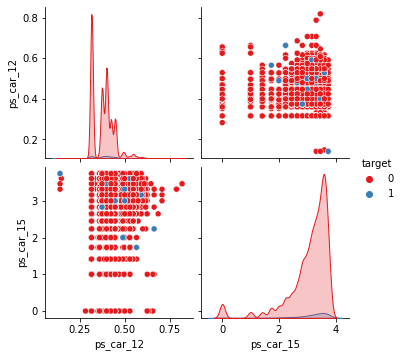

In [ ]:
sample = train.sample(frac=0.05)

var = ['ps_car_12','ps_car_15','target']
sample=sample[var]

sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

Calculated feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

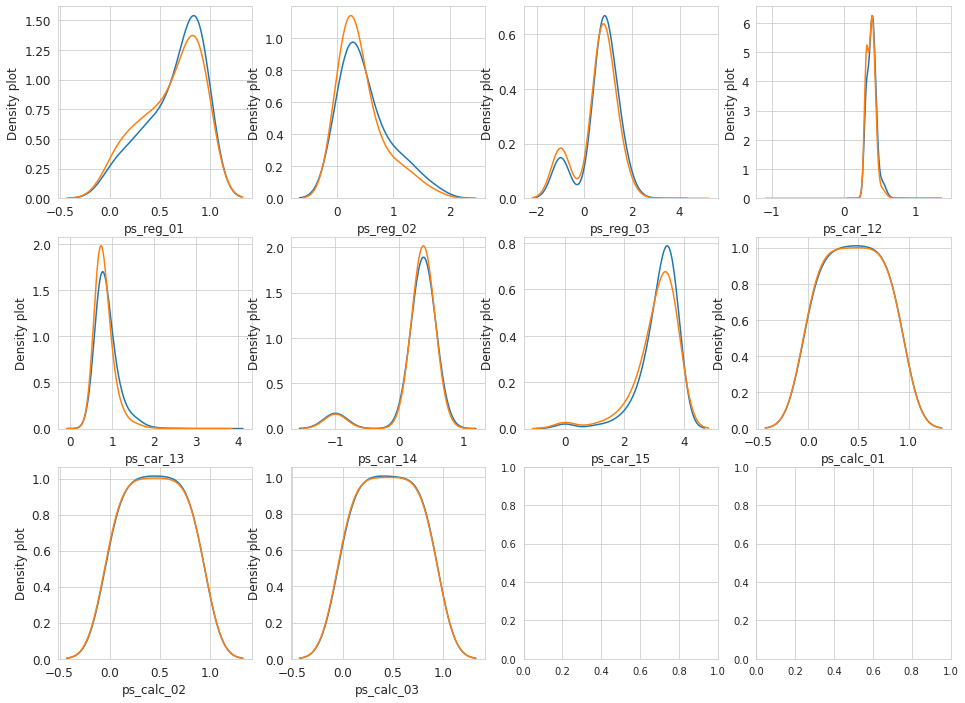

In [ ]:
var = metadata[(metadata.type=='real') & (metadata.preserve)].index

i=0
t1=train.loc[train['target'] ==1]
t0 = train.loc[train['target'] ==0]

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(3,4, figsize=(16,12))

for feature in var :
  i += 1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target=1')
  sns.kdeplot(t0[feature], bw=0.5, label = 'target=0')
  plt.ylabel('Density plot', fontsize=12)
  plt.xlabel(feature, fontsize=12)
  locs,labels=plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


let's visualize the correaltion between the real features

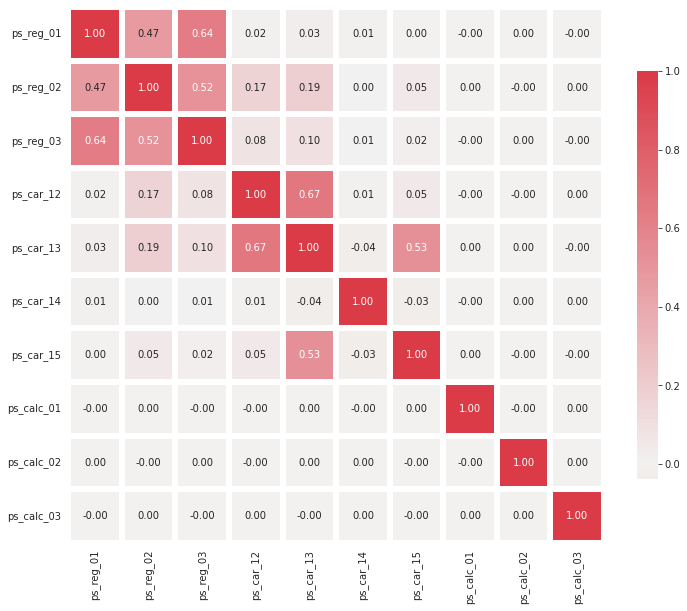

In [ ]:
def corr_heatmap(var) :
  correlations = train[var].corr()

  #Create color amp ranging between two colors
  cmap = sns.diverging_palette(50, 10, as_cmap=True)

  fig, ax = plt.subplots(figsize=(12,10))

  sns.heatmap(correlations, cmap=cmap, annot=True, square=True, vmax=1.0, center=0, fmt='.2f', linewidths=5, cbar_kws={'shrink':.75})

  plt.show()

var=metadata[(metadata.type == 'real') & (metadata.preserve)].index

corr_heatmap(var)

To show the pairs of values that are correlated we use pariplot. Before representing the pairs, we subsample the data, useing only 2% in the sample.

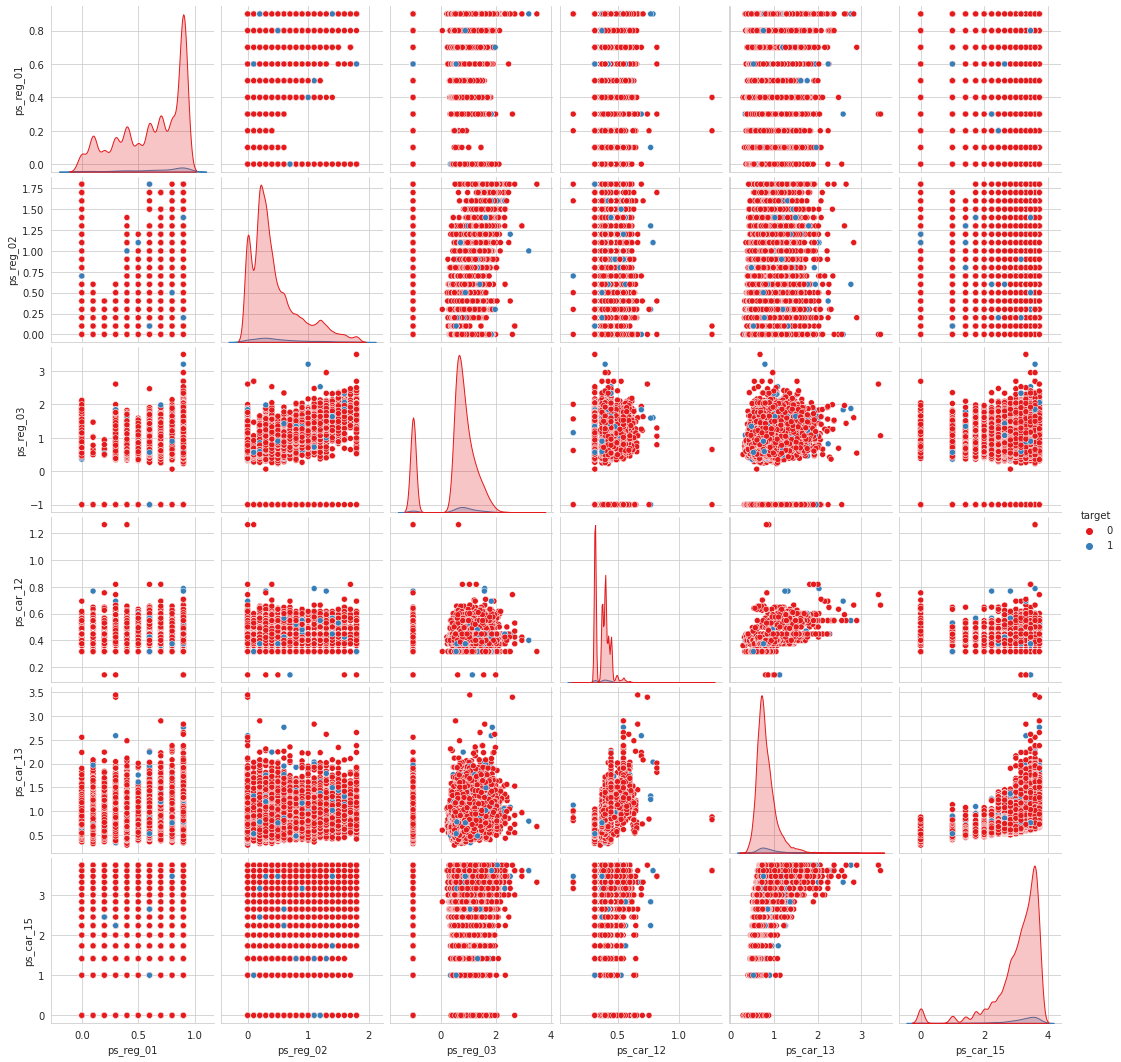

In [ ]:
sample = train.sample(frac=0.05)

var=['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']

sample=sample[var]

sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde' )
plt.show()

#Binary features

In [ ]:
v= metadata[(metadata.type == 'binary') & (metadata.preserve)].index

train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the distribution of the binary data in the training data. With blue we represent the percent of 0 and with red the percent of 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x7f9ad1ed2f10> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

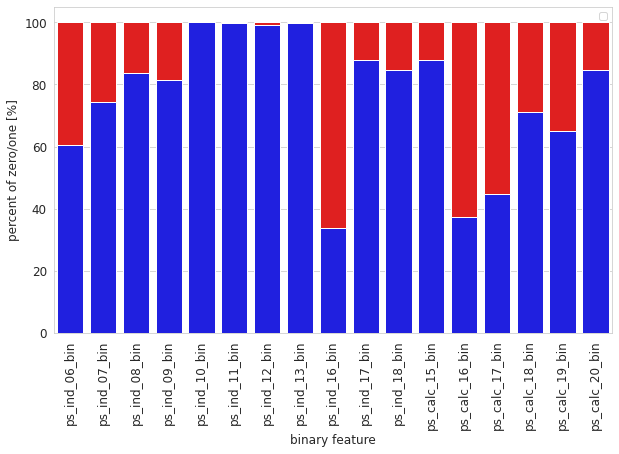

In [ ]:
bin_col = [col for col in train.columns if '_bin' in col]

zero_list = []
one_list = []

for col in bin_col :
  zero_list.append( (train[col] ==0).sum()/train.shape[0]*100)
  one_list.append( (train[col] ==1).sum()/train.shape[0]*100)

plt.figure()

fig, ax = plt.subplots(figsize=(10,6))

#bar plot
p1 = sns.barplot(x=bin_col, y=zero_list, ax=ax, color='blue')
p2 = sns.barplot(x=bin_col, y=one_list, ax=ax, color='red', bottom=zero_list)

plt.xlabel('binary feature', fontsize=12)
plt.ylabel('percent of zero/one [%]', fontsize=12)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( (p1,p2), ('Zero','One'))
plt.show()

the distribution of binary data aznd the corresponding valeus fo target variables

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

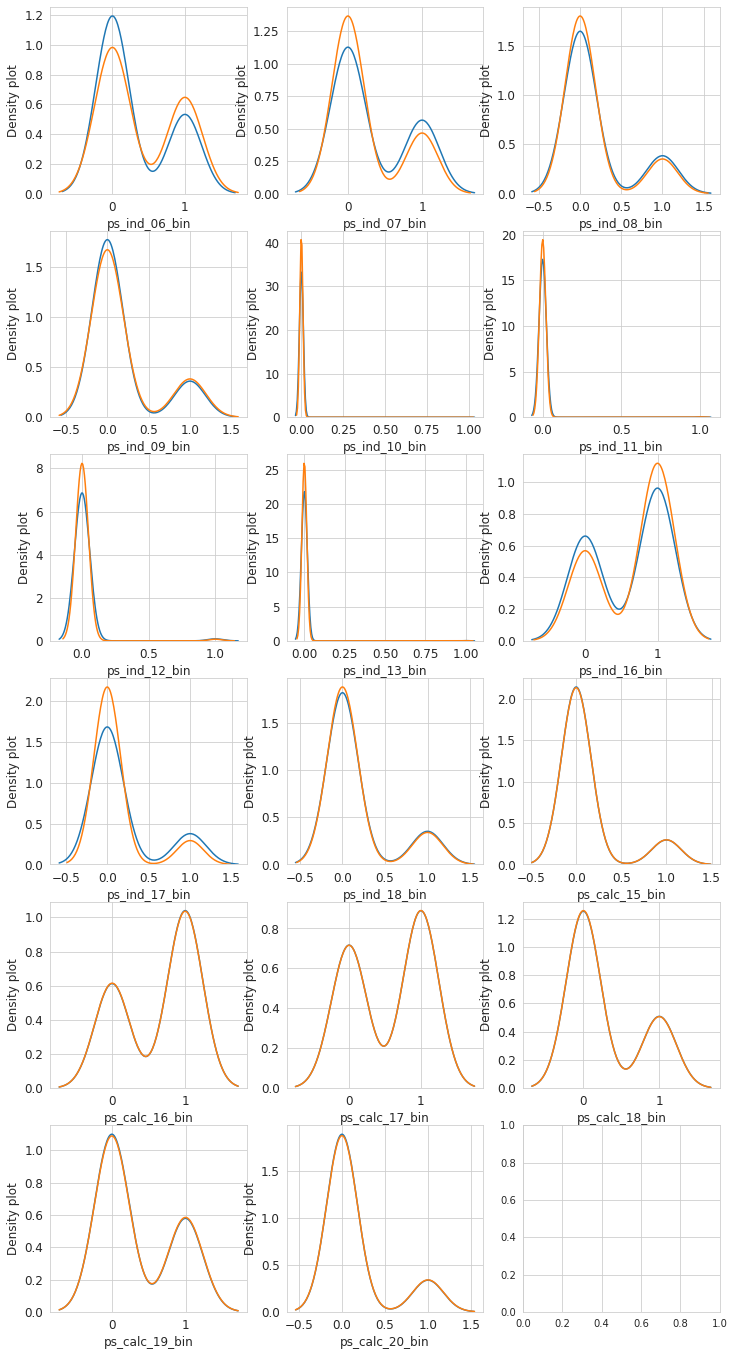

In [ ]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve) ].index

var= [col for col in train.columns if '_bin' in col]
i = 0
t1 = train.loc[train['target'] == 1]
t0 = train.loc[train['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3, figsize=(12,24))


for feature in var :
  i +=1
  plt.subplot(6,3,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target=1')
  sns.kdeplot(t0[feature], bw=0.5, label='target=0')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Density plot', fontsize=12)

  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()  

#Categorical features

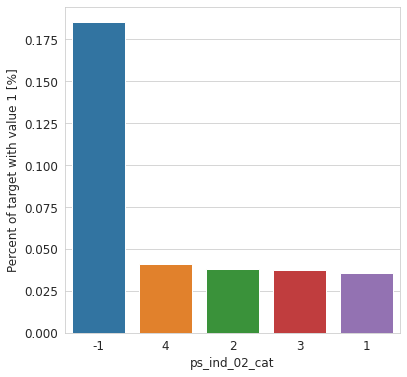

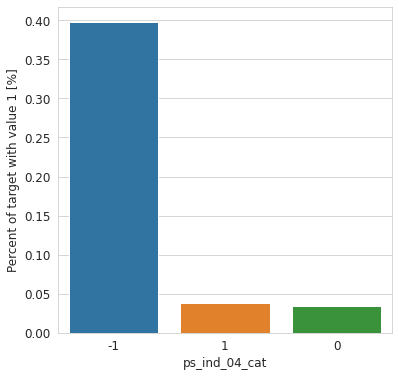

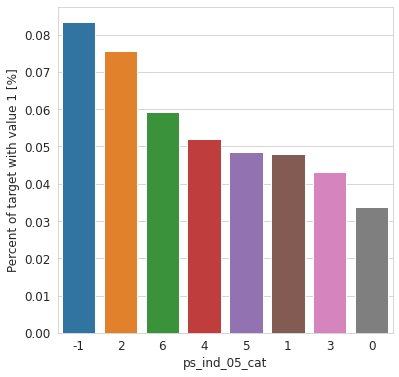

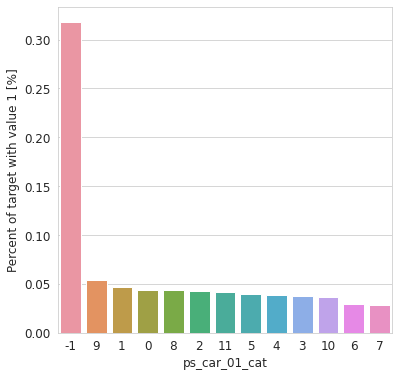

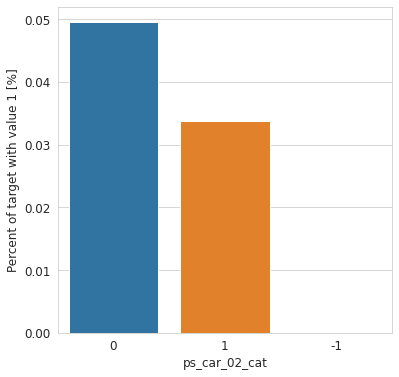

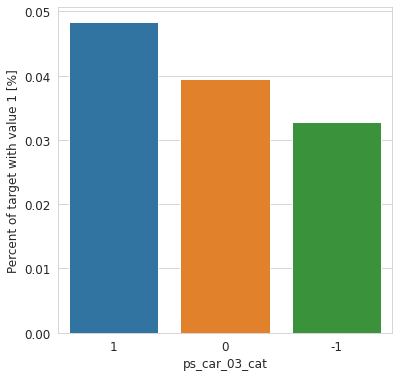

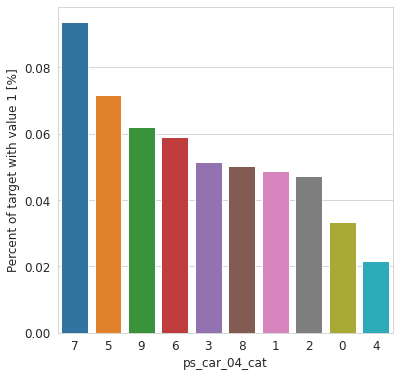

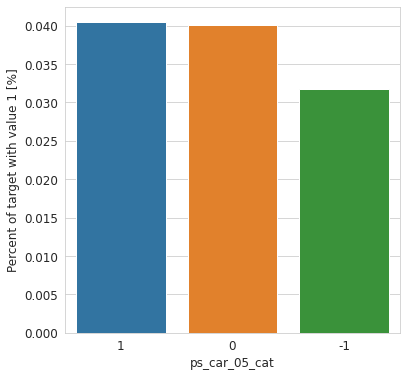

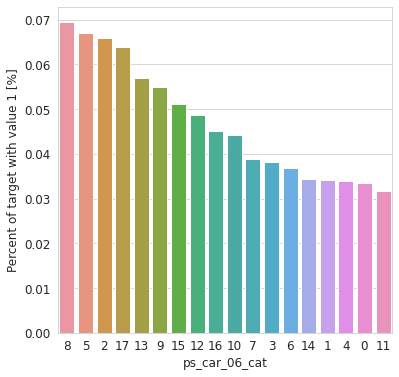

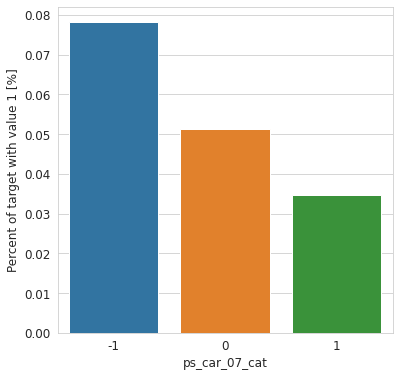

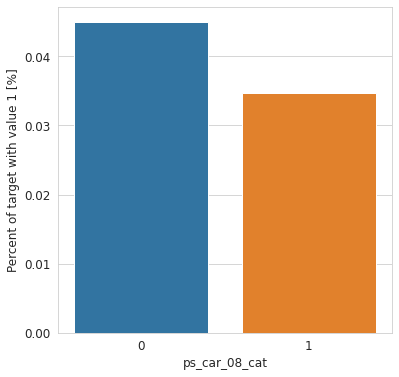

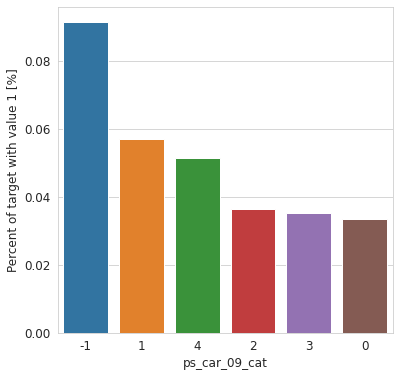

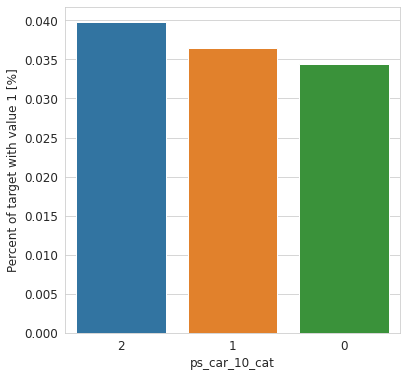

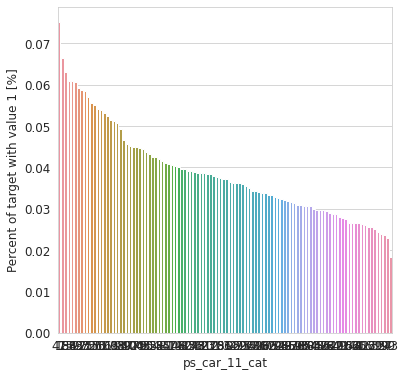

In [ ]:
var= metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var :
  fig, ax = plt.subplots(figsize=(6,6))

  #calculate the percentage of target 1 per category value
  cat_perc = train[ [feature, 'target']].groupby([feature], as_index=False).mean()
  cat_perc.sort_values('target', ascending=False, inplace=True)

  sns.barplot(x=feature, y='target', ax=ax, data=cat_perc, order=cat_perc[feature])

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
  plt.tick_params(axis='both', which='major', labelsize=12)
  plt.show()

Alternativelly we represent the categorical features using density plot. We select values with target 0 and target 1 and represent both density plots on the same graphic.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

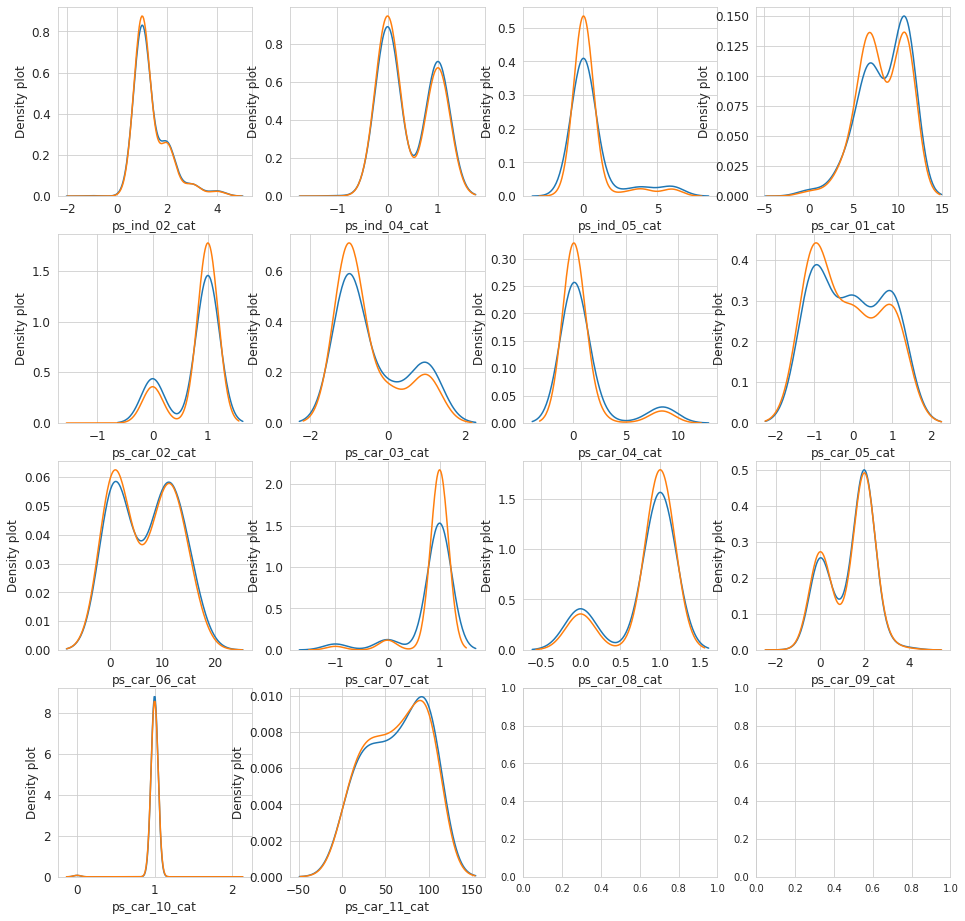

In [ ]:
var = metadata[(metadata.type == 'categirical') & (metadata.preserve)].index

i=0
t1=train.loc[train['target'] ==1]
t0=train.loc[train['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var :
  i +=1
  plt.subplot(4,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target=1')
  sns.kdeplot(t0[feature], bw=0.5, label='target=0')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Density plot', fontsize=12)

  locs, labels = plt.xticks()
  plt.tick_params(axis='both',which='major', labelsize=12)

plt.show()



Data unbalance between train and test data 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

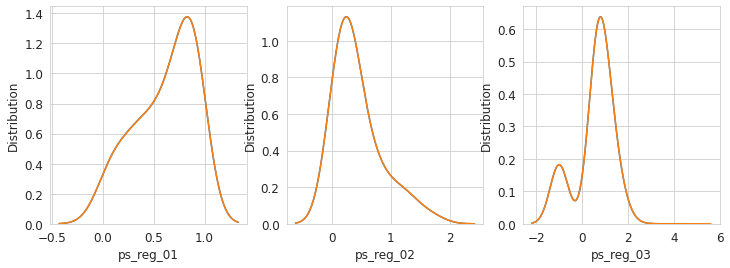

In [ ]:
var=metadata[(metadata.category == 'registration') & (metadata.preserve)].index

#bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i =0

for feature in var :
  i +=1
  plt.subplot(1,3,i)

  sns.kdeplot(train[feature], bw=0.5, label='train')
  sns.kdeplot(test[feature], bw=0.5, label = 'test')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Distribution', fontsize=12)
  locs, labels = plt.xticks()

  plt.tick_params(axis='both',which='major', labelsize=12)

plt.show()

All reg features shows well balanced traina dn test sets.

Let's continue with car features.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

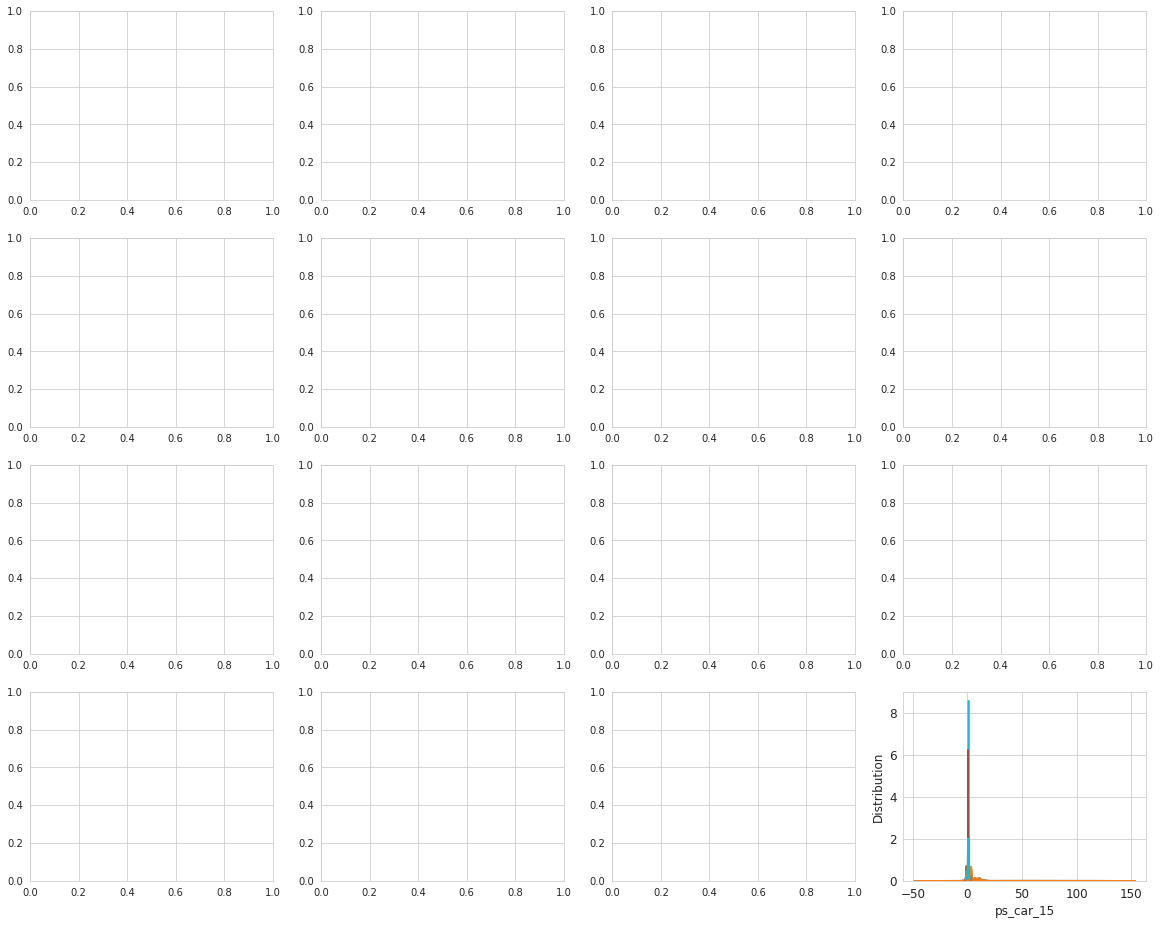

In [ ]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index


#Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))

i=0
for feature in var :
  i +=1
  sns.kdeplot(train[feature], bw=0.5, label='train')
  sns.kdeplot(test[feature], bw=0.5, label='test')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Distribution',fontsize=12)

  locs, labels = plt.xticks()

  plt.tick_params(axis='both',which='major', labelsize=12)

plt.show()

From the car features, all variables look well balanced btw train and test

Let's look now to the ind values

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

ValueError: ignored

<Figure size 432x288 with 0 Axes>

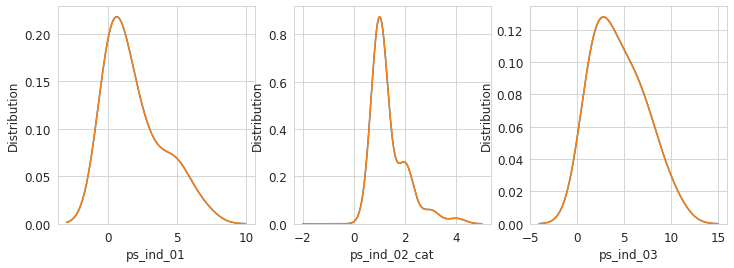

In [ ]:
var=metadata[(metadata.category == 'individual') & (metadata.preserve)].index

#bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i =0

for feature in var :
  i +=1
  plt.subplot(1,3,i)

  sns.kdeplot(train[feature], bw=0.5, label='train')
  sns.kdeplot(test[feature], bw=0.5, label = 'test')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Distribution', fontsize=12)
  locs, labels = plt.xticks()

  plt.tick_params(axis='both',which='major', labelsize=12)

plt.show()

All ind features are well balanced btw train and test

Let's check now calc features.

In [ ]:
var=metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

#bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i =0

for feature in var :
  i +=1
  plt.subplot(1,3,i)

  sns.kdeplot(train[feature], bw=0.5, label='train')
  sns.kdeplot(test[feature], bw=0.5, label = 'test')

  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Distribution', fontsize=12)
  locs, labels = plt.xticks()

  plt.tick_params(axis='both',which='major', labelsize=12)

plt.show()

#Check data quality

inspect the features with missing values

In [ ]:
vars_with_missing = []

for feature in train.columns :
  missings= train[train[feature] == -1][feature].count()
  if missings >0 :
    vars_with_missing.append(feature)
    missings_perc = missings/train.shape[0]

    print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

print('in tital, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
in tital, there are 13 variables with missing values


#Prepare the data for model

###Drop Calc columns



In [ ]:
cols_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]

train=train.drop(cols_to_drop, axis=1)
test=test.drop(cols_to_drop, axis=1)

##Drop variables with too many missing values

In [ ]:
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']

train.drop(vars_to_drop, axis=1, inplace=True)
test.drop(vars_to_drop, axis=1, inplace=True)

metadata.loc[vars_to_drop, 'preserve']=False

In [ ]:
#noise

def add_noise(series, noise_level) :
  return series*(1+noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,tst_series=None,target=None,min_samples_leaf=1,smoothing=1,noise_level=0) :
  assert len(trn_series) == len(target)
  assert trn_series.name == tst_series.name

  temp = pd.concat([trn_series, target], axis=1)

  averages = temp.groupby(trn_series.name)[target.name].agg(['mean','count'])

  smoothing= 1/ (1+np.exp(- (averages['count'] - min_samples_leaf) / smoothing))

  prior = target.mean()

  averages[target.name] = prior * (1-smoothing) + averages['mean']* smoothing

  averages.drop(['mean','count'], axis=1, inplace=True)

  ft_trn_series = pd.merge(
      trn_series.to_frame(trn_series.name),
      averages.reset_index().rename(columns={'index' : target.name, target.name : 'average'}),
      on=trn_series.name,
      how='left').rename(trn_series.name + '_mean').fillna(prior)
  ft_trn_series.index=trn_series.index

  ft_tst_series = pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index' : target.name, target.name : 'average'}),
      on=tst_series.name,
      how='left').rename(tst_series.name + '_mean').fillna(prior)
  ft_tst_series.index=tst_series.index

  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


In [ ]:
train_encode, test_encode = target_encode(train['ps_car_11_cat'],
                                             test['ps_car_11_cat'],
                                             target=train.target,
                                            min_samples_leaf=10,
                                            smoothing=10,
                                            noise_level=0.01)

train['ps_car_11_cat_te'] = train_encode
train.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'preserve'] = False

test['ps_car_11_cat_te'] = test_encode
test.drop('ps_car_11_cat', axis=1, inplace=True)


TypeError: ignored

##Balance target variable



when use under(over)sampling, we can use this equation or use SMOTE in imblearn.over_sampling


ex)

from imblearn.over_sampling import SMOTE

oversaming_instance = SMOTE(K-neighbors = 3)

%%oversampling apply

o_train_x,o_train_y = oversampling_instance.fit_sample(train_x,train_y)




In [ ]:
desired_apriori =0.1

idx_0 = train[train.target ==0].index
idx_1 = train[train.target ==1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

undersampling_rate= ( (nb_1*(1-desired_apriori)) / (nb_0*desired_apriori))
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target0 is {}'.format(undersampling_rate))
print('# records with target 0 after undersampling : {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state=42, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx)+list(idx_1)

train=train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target0 is -0.0378087522972252
# records with target 0 after undersampling : -21684


Replace -1 values with NaN

In [ ]:
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

Dummification cat values

In [ ]:
cat_features = [ a for a in train.columns if a.endswith('cat')]

for column in cat_features :
  temp = pd.get_dummies(pd.Series(train[column]))
  train = pd.concat([train,temp], axis=1)
  train = train.drop([column], axis=1)

for column in cat_features :
  temp = pd.get_dummies(pd.Series(test[column]))
  test = pd.concat([test,temp], axis=1)
  test = test.drop([column], axis=1)

##Drop unsed and target columns

we separate the id and target

In [ ]:
id_test = test['id'].values

target_train = train['target'].values

train = train.drop(['target','id'], axis=1)
test = test.drop('id', axis=1)

In [ ]:
print('train have rows and cols : {} '.format(train.values.shape), '\nTest have rows and cols : {}'.format(test.values.shape))

train have rows and cols : (573528, 194)  
Test have rows and cols : (892816, 194)


#Prepare the model

####Ensable class for cross validation and ensemble

prepare an ensemble class to split the data in FKolds, train and model and ensemble the result.

The class has an init method that accepts 4 parameters :
- self
- n_splits
- stacker
- base_models

A second method, fit_predict has four functions :
- n_splits
- base_models
- perform prediction
- stacker

In [ ]:
class Ensemble(object) :
  def __init__(self, n_splits, stacker, base_models) :
    self.n_splits = n_splits
    self.stacker = stacker
    self.base_modesl = base_models

  def fit_predict(self, x,y,T) :
    x=np.array(x)
    y=np.array(y)
    T=np.array(T)

    folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42).split(x,y))

    s_train = np.zeros( (x.shape[0], len(self.base_models)))
    s_test = np.zeros( (T.shape[0], len(self.base_models)))
    for i, clf in enumerate(self.base_models) :
      s_test_i = np.zeroes( (T.shape[0], self.n_splits))

      for j, (train_idx, test_idx) in enumerate(folds) :
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_holdout = x[test_idx]

        print('Base model {} : fit {} model | fold {}'.format(i+1, str(clf).split('(')[0], j+1))
        clf.fit(x_train, y_train)
        cross_score =cross_val_score(clf, x_train, y_train, cv=3, scoring='roc_auc')
        print('cross score of roc-auc : {:.5f}, gini : {:.5f}'.format(cross_score.mean(), 2*cross_score.mean()-1))
        y_pred = clf. predict_proba(x_holdout)[:,1]

        s_train[test_idx, i] = y_pred
        s_test_i[:,j] = clf.predict_proba(T)[:,1]

      s_test[:,i] = s_test_i.mean(axis=1)

    results = cross_val_score(self.stacker, s_train, y, cv=3, scoring='roc_auc')
    print('Stacker score [gini] : {:.5f}'.format(2*results.mean() -1))

    self.stacker.fit(s_train,y)
    res = self.stakcer.predict_proba(s_test)[:,1]
    return res

####Parameters for the base models

In [ ]:
#ligth gbm params

lgb_params1= {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'min_child_samples' : 500,
    'seed' : 314
}

lgb_params2= {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'min_child_samples' : 500,
    'seed' : 314
}

lgb_params3= {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'min_child_samples' : 500,
    'seed' : 314
}

xgb_params={
  
    'learning_rate' : 0.04,
    'n_estimators' : 490,
    'max_depth' : 4,
    'subsample' : 0.9
}
xgb_params['objective'] =  'binary : logistic',

the code in upside, this will be effective when use use gridsearch 

ex)

lgb_params={
'learning_rate' = [0.1,0.2,0.3,0.25,0.4],

'~~' = [~~]

'~~' = [~~]

}

In [ ]:
# from sklearn.model_selection import GridSearchCV

# learning_rate = [0.1,0.2,0.3,0.25,0.4,0.5,1.0],
# n_estimators = [100,200,300,500,1000],

# gd=GridSearchCV(estimator=LGBMClassifier(),learning_rate=learning_rate, n_estimators=n_estimators, random_state=42 )

# gd.fit(train_x,train_y)





####Initialize the models with the parameters

In [ ]:
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

#Stacking model

log_model = LogisticRegression()

####Initialize the ensambling object

In [ ]:
stack = Ensemble(n_splits =3,
                 stacker=log_model,
                 base_models = (lgb_model1, lgb_model2,lgb_model3,xgb_model )
                 )

##Run the predictive models

Calling the fit_predict method of stack object, we run the training of the base models, predict the target with each mode, ensemble the resutls using the stacker model and output the stacked result.

In [ ]:
y_prediction = stack.fit_predict(train, target_train, test)

#Prepare the submission

In [ ]:
submission = pd.DataFrame()
submission['id'] =id_test
submission['target'] = y_prediction

submission.to_csv('stacked.csv', index=False)